# Homework 10
In this homework you will work on significance testing using permutation tests.

In [1]:
# Don't change this cell; just run it. 
# The result will give you directions about how to log in to the submission system, called OK.
# Once you're logged in, you can run this cell again, but it won't ask you who you are because
# it remembers you. However, you will need to log in once per assignment.
from client.api.notebook import Notebook
ok = Notebook('hw10.ok')
#_ = ok.auth(inline=True)

Assignment: HW 10
OK, version v1.12.5



**1. 1D regression** In a very simple 1D regression setting you will explore the relationship between noise level, amount of data points, and significance of regression slope and intercept. You will create a simple regression line with slope 0.5 and intercept 1.0. Then you will add different levels of noise to the y-variable, use linear regression to estimate the slope and intercept, and check their significance in a permutation test.

Run the cell below with all the python modules you will need for the homework.

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression

import nibabel
import cortex
from nistats.hemodynamic_models import glover_hrf as create_hrf

import matplotlib.pyplot as plt
%matplotlib inline

**(a) Create Fake Data** [1pt]

Create a name called `slope`, set it to `0.5`, and a name called `intercept` and set it to `1.0`. 

Create a 1D array of 1000 random Gaussian values using `np.random.randn` and call it `xn_0` (for *x-noise-0*). 

Then create `yn_0` from `xn_0` by multiplying `xn_0` with `slope` and adding `intercept`. 

Plot `xn_0` and `yn_0` together in a scatterplot in a figure called `fig_xn_0_yn_0`. 

Fit a `LinearRegression` model to `xn_0` and `yn_0` and print its attributes `coef_` and `intercept_`. 

Compare the estimated betas to the true values `slope` and `intercept` using `np.allclose`. 

[ 0.5] 1.0
True


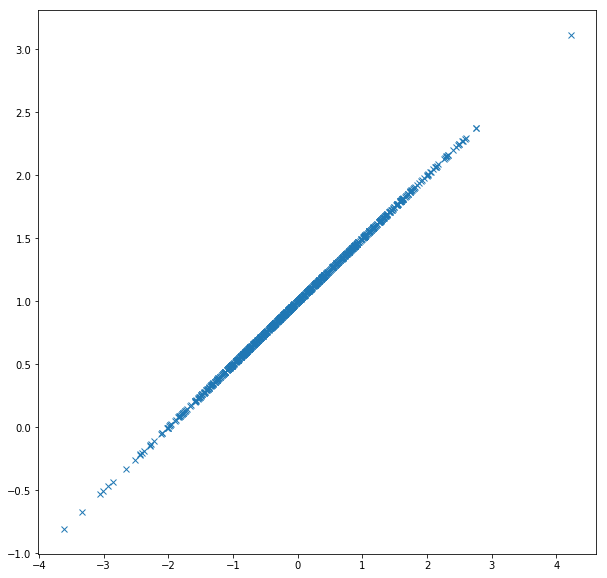

In [3]:
slope = 0.5
intercept = 1.
xn_0 = np.random.randn(1000)
yn_0 = slope * xn_0 + intercept
fig_xn_0_yn_0 = plt.figure(figsize=(10, 10))
plt.plot(xn_0, yn_0, 'x')
linreg = LinearRegression()
linreg.fit(xn_0[:, np.newaxis], yn_0)
print(linreg.coef_, linreg.intercept_)
print(np.allclose([slope, intercept], [linreg.coef_[0], linreg.intercept_]))

**(b) Adding Noise** [1pt] Now you will create noisy versions of `y` and plot them. 

Use `np.random.randn` to create a 1D array that is the same shape as `yn_0` and call it `noise`. 

Create three new `y`-vectors called `yn_1, yn_10, yn_100` that have different noise levels by adding `1, 10, 100` times `noise` to `yn_0` respectively. Also store the values of `.coef_` and `.intercept_` from each model estimated into `s0, sn_1, sn_10, sn_100`, and `i0, in_1, in_10, in_100` respectively so they can later be compared to a null distribution of slopes and intercepts for determining significance.

Fit a linear model of `xn_0` onto each `y` vector and use `.predict` to compute the regression line for each model, and store those regression lines in `yhat_n0, yhat_n, yhat_n10, yhat_n100`.

Create a figure named `fig_noisy` of size `(20, 5)`.

Use `plt.subplot` to make 4 scatterplots horizontally next to each other (all in 1 row with 4 columns), in which you plot the x data (without noise) to the 4 y data vectors that have varying amounts of noise. To be precise, plot `(xn_0, yn_0), (xn_0, yn_1), (xn_0, yn_10), (xn_0, yn_100)` respectively. 

Add a plot for the regrssion line (yhat) to each plot. 

Give each subplot a title containing noise level (`0, 1, 10, 100`) and respective slope and intercept (up to 2 digits after the decimal point). 

Note that in the plots the lines will appear to have quite different slopes because the y-axis scales will be different. (If you want to compare slopes, you can use `plt.axis([-4, 4, -4, 4])` on all the plots to make them be on the same scale, but look at the point clouds without scaling as well)

[-4, 4, -4, 4]

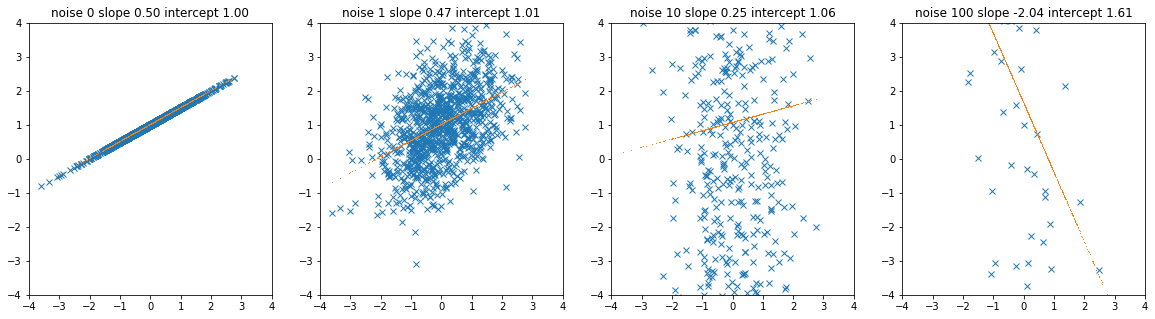

In [4]:
noise = np.random.randn(*yn_0.shape)
yn_1 = yn_0 + 1 * noise
yn_10 = yn_0 + 10 * noise
yn_100 = yn_0 + 100 * noise

lr = LinearRegression()

fig_noisy = plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.plot(xn_0, yn_0, 'x')
lr.fit(xn_0.reshape(-1, 1), yn_0)
plt.plot(xn_0, lr.predict(xn_0.reshape(-1, 1)), ',')
s0, i0 = lr.coef_[0], lr.intercept_
plt.title("noise {} slope {:0.2f} intercept {:0.2f}".format(0, s0, i0))
plt.axis([-4, 4, -4, 4])

plt.subplot(1, 4, 2)
plt.plot(xn_0, yn_1, 'x')
lr.fit(xn_0.reshape(-1, 1), yn_1)
plt.plot(xn_0, lr.predict(xn_0.reshape(-1, 1)), ',')
sn_1, in_1 = lr.coef_[0], lr.intercept_
plt.title("noise {} slope {:0.2f} intercept {:0.2f}".format(1, sn_1, in_1))
plt.axis([-4, 4, -4, 4])

plt.subplot(1, 4, 3)
plt.plot(xn_0, yn_10, 'x')
lr.fit(xn_0.reshape(-1, 1), yn_10)
plt.plot(xn_0, lr.predict(xn_0.reshape(-1, 1)), ',')
sn_10, in_10 = lr.coef_[0], lr.intercept_
plt.title("noise {} slope {:0.2f} intercept {:0.2f}".format(10, sn_10, in_10))
plt.axis([-4, 4, -4, 4])

plt.subplot(1, 4, 4)
plt.plot(xn_0, yn_100, 'x')
lr.fit(xn_0.reshape(-1, 1), yn_100)
plt.plot(xn_0, lr.predict(xn_0.reshape(-1, 1)), ',')
sn_100, in_100 = lr.coef_[0], lr.intercept_
plt.title("noise {} slope {:0.2f} intercept {:0.2f}".format(100, sn_100, in_100))
plt.axis([-4, 4, -4, 4])


**(c) Permutation Test** [1pt] In order to do permutation testing, you need to compute a null distribution to compare the above estimates with. In this part you will create this distribution for the first 10 entries of the dataset `(xn_0, yn_0)`.


Because there are no complicated temporal dependencies in the fake data generated here, we can permute the entries of the y-data many times instead of blocks of x like we do for fMRI data. We use permutations to break the relationship between the data and the model in order to see whether the unpermuted setting looks different in any way. Whether we permute the x-side or the y-side doesn't matter if there are no temporal dependencies. Permuting the y-side many times makes it possible for us to exploit the fact that the scikit-learn `LinearRegression` models can do many regressions at once. You will make a Y-matrix with 1000 columns, where each column is a permuted version of yn_0. As for computation, this is like performing simple linear regression on 1000 voxels.

Use slicing to create `xn_0_10` and `yn_0_10` which should contain the first ten entries of `xn_0` and `yn_0` respectively.

Now create 1000 permuted versions of `yn_0_10` by doing the following:
Preallocate the array of permuted y vectors by creating a 2-D array called `permuted_Y_10` of shape `(10, 1000)`. 


Create a `for` loop that iterates over the variable `i` going from 0 to 1000 (the number of columns of `permuted_Y_10`). Inside the loop, set the `i`-th column of `Y_10` to `yn_0_10` using slicing. Then use `np.random.shuffle` to shuffle that same column.

Now perform a linear regression of `xn_0_10` on all 1000 columns of `permuted_Y_10` in one call to `.fit`. Extract the slopes into a name called `permuted_slopes_0_10`.

Do a linear regression on `xn_0_10` and `yn_0_10` and store the slope in `slope_0_10`.

In [5]:
xn_0_10 = xn_0[:10]
yn_0_10 = yn_0[:10]
permuted_Y_10 = np.zeros((10, 1000))
for i in range(permuted_Y_10.shape[1]):
    permuted_Y_10[:, i] = yn_0_10
    np.random.shuffle(permuted_Y_10[:, i])
lr = LinearRegression().fit(xn_0_10.reshape(-1, 1), permuted_Y_10)
permuted_slopes_0_10 = lr.coef_
permuted_intercepts_0_10 = lr.intercept_
lr.fit(xn_0_10.reshape(-1, 1), yn_0_10)
slope_0_10, intercept_0_10 = lr.coef_, lr.intercept_

**(d) Visualize Null Distribution and Test Statistic** [0.5pts] Now you can compare the null distributions with the test statistics (the slope and intercept) by visualizing the two. 

Display `permuted_slopes_0_10` in a histogram with 100 bins. Then draw a vertical line using `np.vlines` at the x-value of `slope_0_10` (make it start at y=0 and end at 25 or so, where the histogram peaks).


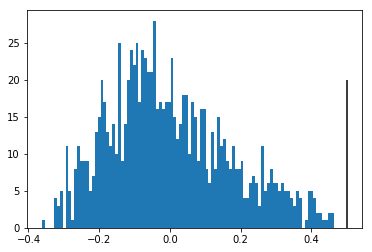

In [6]:
_ = plt.hist(permuted_slopes_0_10, bins=100)
plt.vlines([slope_0_10], 0, 20)

**(e) Compute p-value** [0.5pts] Now you can compute the p-values by finding the proportion of values in the null distribution that are greater than the test statistic. Make sure to use the corrected formula learned in class though! Compute the p-values for the slope and store them in `p_slope_0_10`, and print it.

In [7]:
p_slope_0_10 = ((permuted_slopes_0_10 > slope_0_10).sum() + 1) / (permuted_Y_10.shape[1] + 1)
print(p_slope_0_10)

0.000999000999001


**(f) Explore effects of noise on p-value** [1pt]

The idea of this exercise is to look at the effect that varying values of noise have on p-values. The previous example was significant with only 10 data points because there was no noise, so let's now take a look at the examples created above that have more noise, still using only 10 samples of each: 

Set a counter to 1

In a for-loop, loop over `noise_level in (0.0, 1.0, 10.0, 100.0)`: In it 
- Create `cur_y_noisy` by adding `noise_level` times `noise` to `yn_0`. Then create `cur_y_noisy_10` by selecting the first 10 elements of `cur_y_noisy` using slicing.

- Now do the for loop in which you fill the columns of `permuted_Y_10` with shuffled versions of `cur_y_noisy_10`. Then perform the regression of `xn_0_10` against `permuted_Y_10`.

- Store the permuted slopes in `cur_permuted_slopes`.

- Do the unpermuted regression of `xn_0_10` and `cur_y_noisy_10` and store the slope in `cur_slope`.

- Compute `cur_pvalue` using `cur_slope` and `cur_permuted_slopes` as above.

- Create a subplot (4 in one row), select the one indicated by the counter, and plot `cur_permuted_slopes` as a histogram with 100 bins, and `cur_slope` as a `vline`. Add a title indicating the `p-value` and the `noise_level` to **3 digits after the decimal point**

- increment the counter

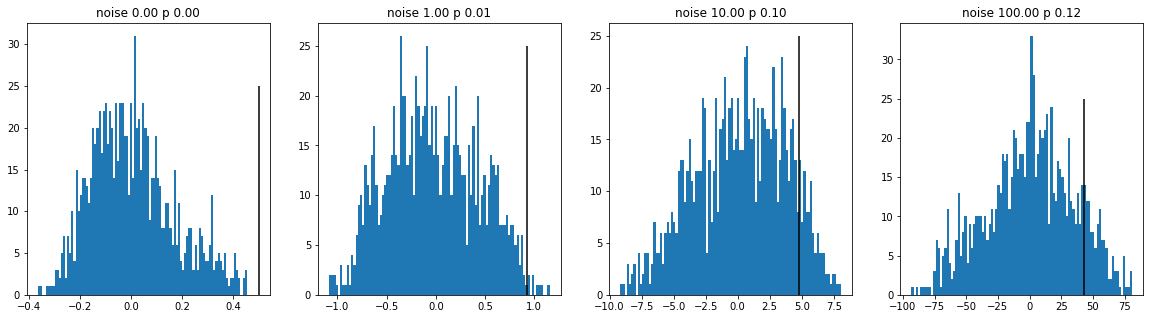

In [8]:
counter = 1

plt.figure(figsize=(20, 5))
for noise_level in (0., 1., 10., 100.):
    y_noisy = yn_0 + noise_level * noise
    y_noisy_10 = y_noisy[:10]
    cur_slope = LinearRegression().fit(xn_0_10.reshape(-1, 1), y_noisy_10).coef_

    for i in range(permuted_Y_10.shape[1]):
        permuted_Y_10[:, i] = y_noisy_10
        np.random.shuffle(permuted_Y_10[:, i])
    cur_permuted_slopes = LinearRegression().fit(xn_0_10.reshape(-1, 1), permuted_Y_10).coef_
    cur_pvalue = ((cur_permuted_slopes > cur_slope).sum() + 1) / (permuted_Y_10.shape[1] + 1)

    plt.subplot(1, 4, counter)
    plt.hist(cur_permuted_slopes, bins=100)
    plt.vlines([cur_slope], 0, 25)
    plt.title("noise {:0.2f} p {:0.2f}".format(noise_level, cur_pvalue))
    counter += 1


**(g) Explore effects of noise and data size on p-value** [1pt] Now you'll see the effects that changing the number of data points has on p-values, and how noise interacts with those effects.

Repeat what you did in **(f)** using `100` and `1000` samples, and plot the results for `10, 100, 1000` samples and noise levels of `0, 1, 10, 100` into three lines of four plots.

You can reuse the code from **(f)**: Create an outer for-loop over `n_samples in (10, 100, 1000)`, in which you allocated `permuted_Y` to be of shape `(n_samples, 1000)`, and then use the two nested for-loops from above to compute the permutation distributions and plots. You will have to shorten `y_noisy` to `:n_samples` instead of `:10`.

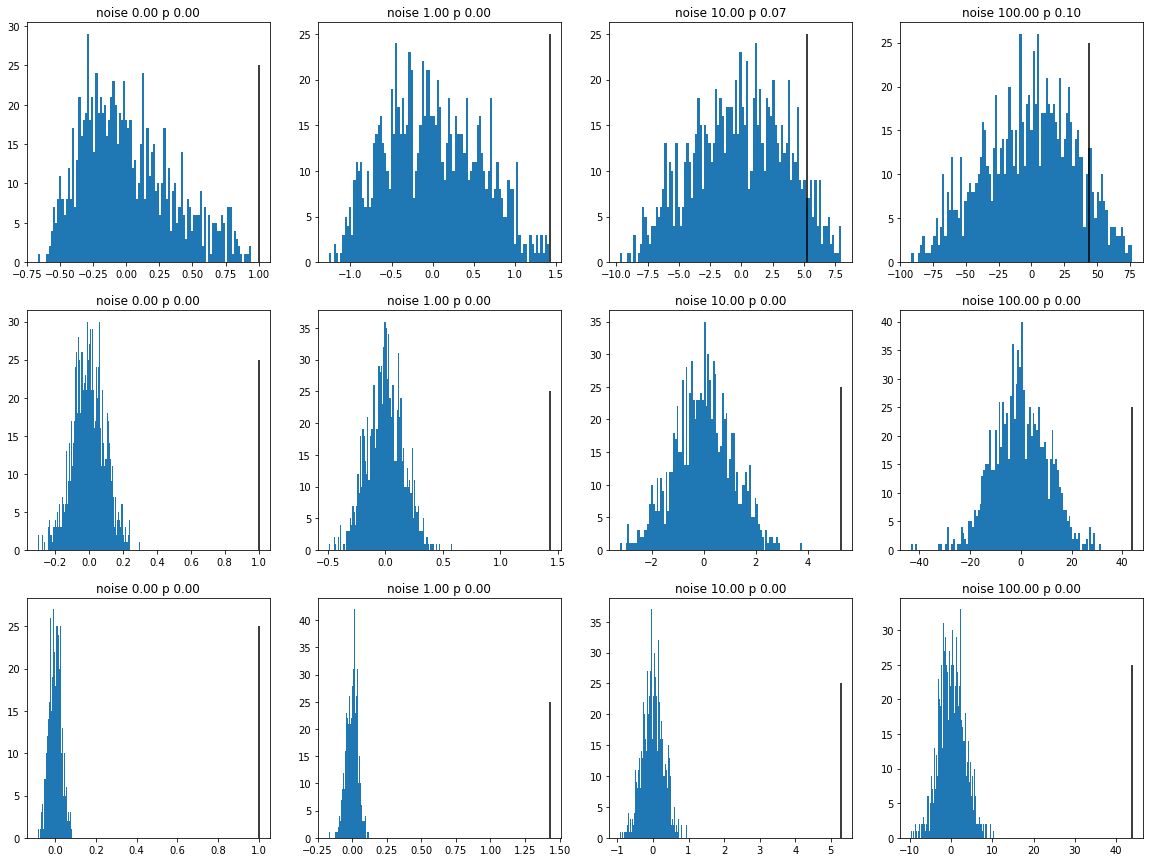

In [9]:
plt.figure(figsize=(20, 15))
n_permutations = 1000
counter = 1
for n_samples in (10, 100, 1000):
    permuted_Y = np.zeros((n_samples, n_permutations))
    for noise_level in (0., 1., 10., 100.):
        y_noisy = xn_0 + noise_level * noise
        y_noisy_10 = y_noisy[:10]
        cur_slope = LinearRegression().fit(xn_0_10.reshape(-1, 1), y_noisy_10).coef_

        for i in range(permuted_Y_10.shape[1]):
            permuted_Y[:, i] = y_noisy[:n_samples]
            np.random.shuffle(permuted_Y[:, i])
        cur_permuted_slopes = LinearRegression().fit(xn_0[:n_samples].reshape(-1, 1), permuted_Y).coef_
        cur_pvalue = ((cur_permuted_slopes > cur_slope).sum() + 1) / (permuted_Y_10.shape[1] + 1)

        plt.subplot(3, 4, counter)
        plt.hist(cur_permuted_slopes, bins=100)
        plt.vlines([cur_slope], 0, 25)
        plt.title("noise {:0.2f} p {:0.2f}".format(noise_level, cur_pvalue))
        counter += 1

**2. Contrast maps**
This exercise aims at creating p-value maps for the motor contrasts from last homework.

Run all the below cells. They are copied from the lecture. You will need to use the functions and data from these cells to complete this exercise.


In [10]:
motor_data_file = "/data/cogneuro/fMRI/motor/s01_motorloc.nii.gz"

In [11]:
def load_nifti(filename, zscore=True, mask=None):
    img = nibabel.load(filename)
    data = img.get_data().T
    if mask is not None:
        data = data[:, mask]
    if zscore:
        data -= data.mean(0)
        data /= data.std(0) + 1e-8
    return data

In [12]:
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')

In [13]:
motor_data = load_nifti(motor_data_file, mask=mask)

In [14]:
motor_categories = np.load("/home/jovyan/motorloc_experimental_conditions.npy")
unique_motor_categories = np.unique(motor_categories)
unique_motor_categories

array(['move eyes', 'move foot', 'move hand', 'move mouth', 'rest', 'speak'], 
      dtype='<U10')

In [15]:
stimulus_vectors = []
for category in unique_motor_categories:
    stimulus_vectors.append(motor_categories == category)
stimulus_design = np.stack(stimulus_vectors, axis=1)

In [16]:
def convolve_designmat(designmat):
    
    num_stim_types = designmat.shape[1]
    n = designmat.shape[0]

    # create the hrf
    hrf = create_hrf(tr=2, oversampling=1, time_length=32)
    
    # create the current shuffled design matrix using the shuffled indices
    cur_designmat = np.zeros(designmat.shape)
    for cur_column in np.arange(num_stim_types):
        cur_stim_vec_shuffled = designmat[:,cur_column]
        cur_designmat[:,cur_column] = np.convolve(cur_stim_vec_shuffled, hrf)[:n]        

    return cur_designmat

In [17]:
def permutation_test(x, y, shuffle_func, test_stat_func, test_stat_param=None, num_resamples=1000,
                    return_null_dist=True):
    n = x.shape[0]
    num_dependent = 1 if y.ndim == 1 else y.shape[1]
    if return_null_dist:
        null_dist = np.zeros((num_resamples,num_dependent))
    else:
        null_dist = None
    # calculate the real test statistic for the x and y data, passing in the test_stat
    # param if one was passed in
    if test_stat_param is None:
        real_test_stat = test_stat_func(x,y)
    else:
        real_test_stat = test_stat_func(x,y,test_stat_param)

    num_greater_null = np.zeros(y.shape[1], dtype=int)
    for cur_iter in range(num_resamples):

        # resample x without replacement by shuffling the indices in x using a function
        x_shuffle = shuffle_func(x)

        # calculate the test statistic using the function passed in
        if test_stat_param is None:
            test_stat = test_stat_func(x_shuffle,y)
        else:
            test_stat = test_stat_func(x_shuffle,y,test_stat_param)
        
        num_greater_null[test_stat > real_test_stat] += 1
        # store the test statistic in the null distribution vector
        if return_null_dist:
            null_dist[cur_iter,:] = test_stat
        
    
    # calculate the p-value
    p_value = (num_greater_null + 1) / (num_resamples + 1)
    
    # return the p-value and the null distribution
    return (p_value, null_dist, real_test_stat)

In [18]:
def shuffle_blocks(x, block_size=10):
    
    n = x.shape[0]
    n_blocks = n // block_size
    n_block_samples = n_blocks * block_size

    # shuffle the indices by blocks
    indices = np.arange(n_block_samples)
    blocked_indices = indices.reshape([n_blocks, block_size])
    np.random.shuffle(blocked_indices)
    indices_block_shuffled = blocked_indices.reshape(-1)
    adjusted_indices = np.concatenate((indices_block_shuffled, np.arange(n_block_samples, len(x))))
    x_block_shuffled = x[adjusted_indices]

    return x_block_shuffled

In [19]:
def calc_contrast_convolve(designmat, bold_data, contrast_idxs):
    # convolve the stimulus design matrix with the hrf and return it
    designmat_conv = convolve_designmat(designmat)
    
    # fit the model on the convolved design matrix
    model = LinearRegression()
    model.fit(designmat_conv, bold_data)
    contrast = model.coef_[:, contrast_idxs[0]] - model.coef_[:, contrast_idxs[1]]
    return contrast

**(a)** [0.5pts] In last week's homework you learned what contrasts are used to localizer the motor cortex ROIs. Below is a reminder of those contrasts. Here you'll create tuples to quantify the indices into the design matrix that are needed to create those contrasts.

First print out the order that the motor tasks are stored in the design matrix by finding the relevant name from the code that creates the design matrix above.

Then create one 2 value tuple for each contrast, where the values are the column indices of the motor task design matrix. The second index represents the motor task that will be subtracted from the first. Call each tuple `contrast_idxs_XXXX`, where `XXXX` is the name of each of the contrasts listed below:

- eyes vs rest
- foot vs rest
- hand vs rest
- speak vs rest
- speak vs mouth


In [20]:
contrast_idxs_eyes_rest = (0, 4)
contrast_idxs_foot_rest = (1, 4)
contrast_idxs_hand_rest = (2, 4)
contrast_idxs_speak_rest = (5, 4)
contrast_idxs_speak_mouth = (5, 3)


**(b)** [1pt] Now you're going to do a permutation test on the `eyes_rest` contrast you just defined. To do this use the `permutation_test` from the lecture to compute `contrast_eyes_rest_pvalue, null_dists_contrast_eyes_rest, contrast_eyes_rest`. Choose 100 permutations, which should take about 5 minutes to calculate. 

For voxels `[34854, 37594, 36630, 25004, 12135, 0]`, plot the null distribution histogram (20 bins) and the actual contrast value as a `vline`. Make a figure with 6 subplots for this, arranged in two lines of three plots.

In [21]:
(contrast_eyes_rest_pvalue, null_dists_contrast_eyes_rest, contrast_eyes_rest) = permutation_test(
    stimulus_design, motor_data, shuffle_blocks, calc_contrast_convolve, contrast_idxs_eyes_rest, 100)



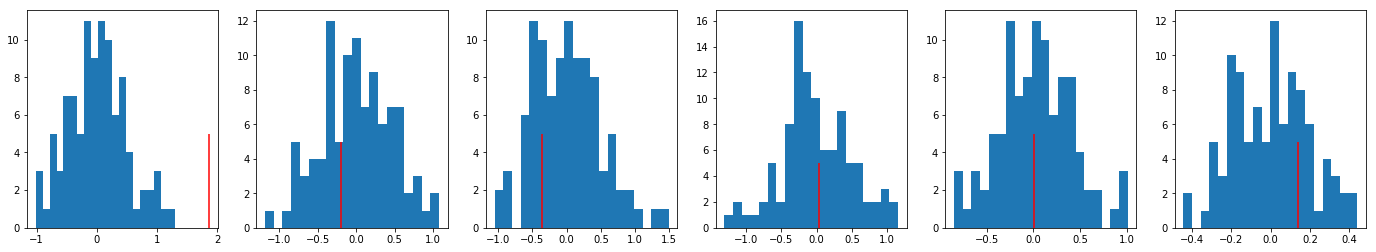

In [22]:
counter = 1
plt.figure(figsize=(24, 4))

for v in [34854, 37594, 36630, 25004, 12135, 0]:
    
    plt.subplot(1, 6, counter)
    plt.hist(null_dists_contrast_eyes_rest[:, v], bins=20)
    plt.vlines([contrast_eyes_rest[v]], 0, 5, 'r')
    counter += 1

**(c)** [0.5pts] Plot the negative log p-values for `eyes_rest` on a flatmap.

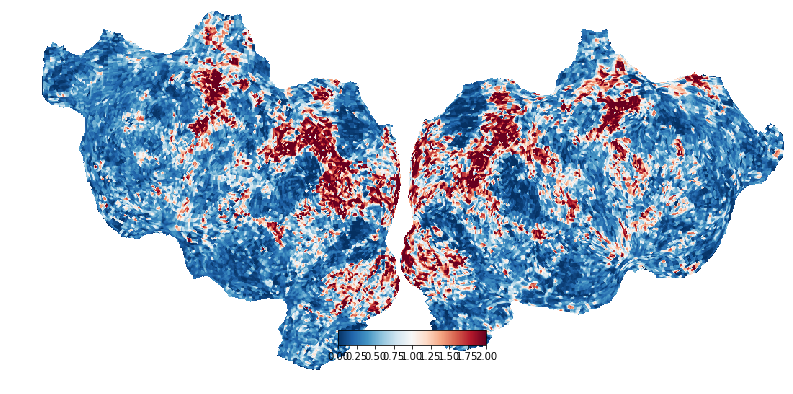

In [26]:
vol = cortex.Volume(-np.log10(contrast_eyes_rest_pvalue), 's01', 'catloc')
cortex.quickshow(vol)
plt.show()

**(d)** [0.5 pts]
Use all the p-values you just calculated for the `eyes_rest` localizer and make a mask that indicates which voxels are significant, and which aren't. Use a threshold of `p < 0.01`  because that value will choose only the voxels that were entirely above their null distribution.

Plot that mask as a flatmap. You'll want to limit the range of values assigned to the colormap since the mask can be either `True` or `False`, meaning `1` and `0`. To do that, specify `vmin=0` and `vmax=1` as arguments to the `cortex.Volume` that you create. Also use the `Reds` colormap.

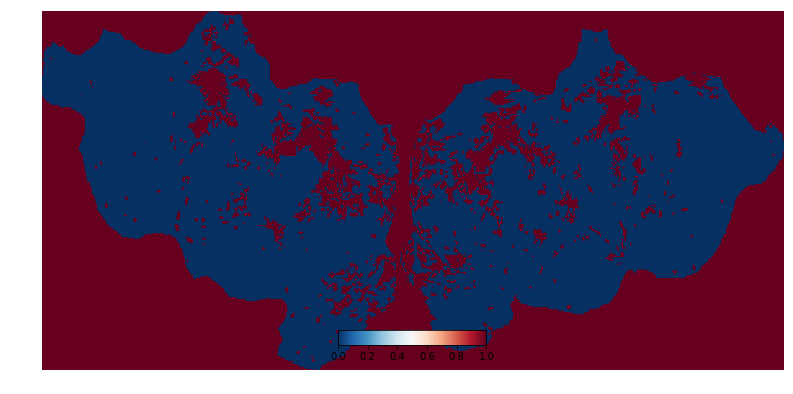

In [28]:
vol = cortex.Volume(contrast_eyes_rest_pvalue < .01, 's01', 'catloc')
cortex.quickshow(vol)
plt.show()

**(e)** [1.5pts] Compute permutation tests for the four other contrasts listed above and display their thresholded (p < 0.01) p-value-maps. Use `return_null_dist=False` in `permutation_test` to avoid memory problems.

In [55]:
(contrast_foot_rest_pvalue, null_dists_contrast_foot_rest, contrast_foot_rest) = permutation_test(
    stimulus_design, motor_data, shuffle_blocks, calc_contrast_convolve, contrast_idxs_foot_rest, 1000, return_null_dist=False)

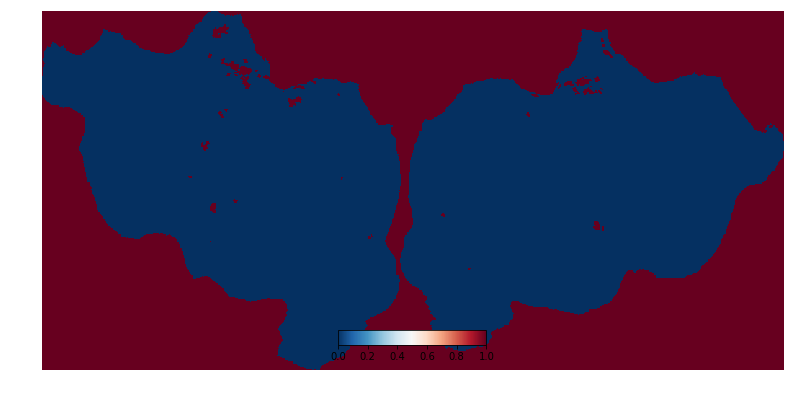

In [63]:
vol = cortex.Volume(contrast_foot_rest_pvalue < .001, 's01', 'catloc')
cortex.quickshow(vol)
plt.show()

In [57]:
(contrast_hand_rest_pvalue, null_dists_contrast_hand_rest, contrast_hand_rest) = permutation_test(
    stimulus_design, motor_data, shuffle_blocks, calc_contrast_convolve, contrast_idxs_hand_rest, 1000, return_null_dist=False)

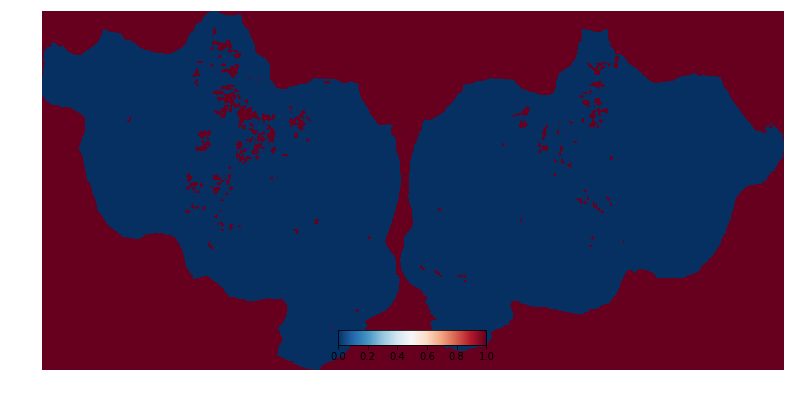

In [64]:
vol = cortex.Volume(contrast_hand_rest_pvalue < .001, 's01', 'catloc')
cortex.quickshow(vol)
plt.show()

In [59]:
(contrast_speak_rest_pvalue, null_dists_contrast_speak_rest, contrast_speak_rest) = permutation_test(
    stimulus_design, motor_data, shuffle_blocks, calc_contrast_convolve, contrast_idxs_speak_rest, 1000, return_null_dist=False)

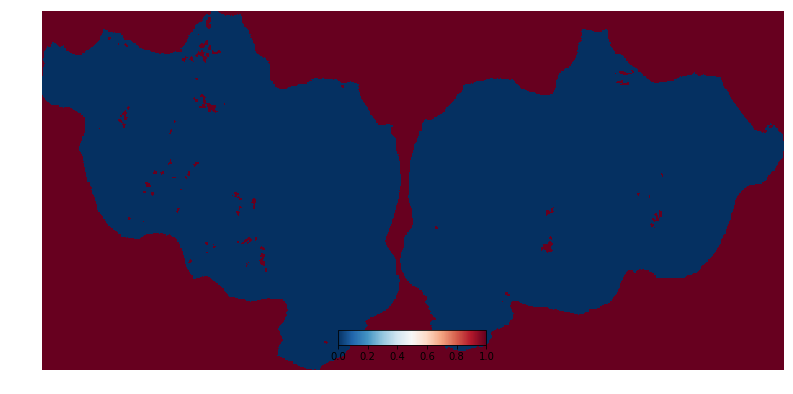

In [65]:
vol = cortex.Volume(contrast_speak_rest_pvalue < .001, 's01', 'catloc')
cortex.quickshow(vol)
plt.show()

In [61]:
(contrast_speak_mouth_pvalue, null_dists_contrast_speak_mouth, contrast_speak_mouth) = permutation_test(
    stimulus_design, motor_data, shuffle_blocks, calc_contrast_convolve, contrast_idxs_speak_mouth, 1000, return_null_dist=False)

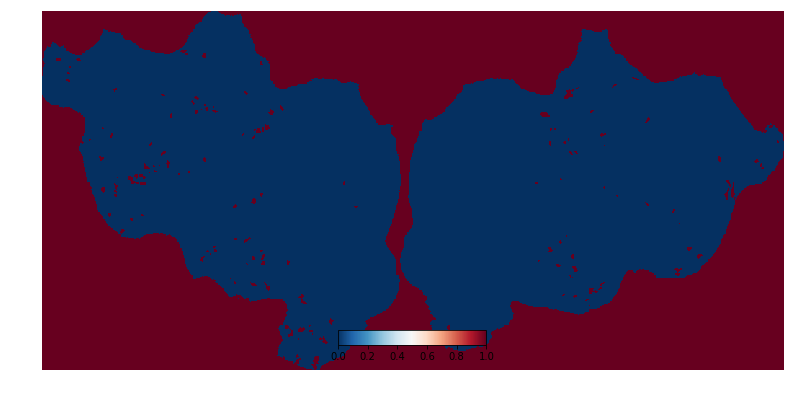

In [66]:
vol = cortex.Volume(contrast_speak_mouth_pvalue < .001, 's01', 'catloc')
cortex.quickshow(vol)
plt.show()

Don't forget to submit!

In [29]:
#_ = ok.submit()